# DefWeb : Variational AutoEncoder(VAE)

#### Description:
#### - In this Code, we implement our VAE to obfuscate Website Fingerprints(WFs)
#### - We create 100-dimensional latent space for 100 website cluster (2-dimensional latent space for 2 website cluster)
#### - Input: Preprocessed WFs
#### - Output: Reconstructed WFs



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"

import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv1D, Conv1DTranspose,  Flatten, Dense, Lambda, MaxPooling1D, BatchNormalization, Dropout, Activation, UpSampling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tensorflow import keras

from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


K.clear_session()
#np.random.seed(237)

2023-09-20 17:31:43.086337: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Input Data

In [2]:
#For two websites (Google.com and Amazon.com)
train_X = pd.read_csv('../../Data_Collection/trainX_2_US_Chrome.csv', header=None)
train_Y = pd.read_csv('../../Data_Collection/trainY_2_US_Chrome.csv', header=None)

In [3]:
trainX = train_X.to_numpy()
trainY = train_Y.to_numpy()

# Shuffled 
### In this portion, we shuffled within the website clusters to make sure the VAE model learn efficiently

In [4]:
website_num=2
samples=trainX.shape[1]

In [5]:
websites_test = [trainX[i:i + 100] for i in range(0, len(trainX), 100)]
websites_test=np.asarray(websites_test)

In [6]:
web_num =0
for web_num in range (0,website_num):
       np.random.shuffle(websites_test[web_num])


In [7]:
websites_shuffled=np.reshape(websites_test,(website_num*100,samples))

In [8]:
trainX = np.expand_dims(trainX,axis=2)

In [9]:
websites_shuffled = np.expand_dims(websites_shuffled,axis=2)

# Normalized
### In this portion, we normalized WF Dataset.

In [10]:
minimum = np.amin(trainX)
maximum = np.amax(trainX)
trainX_normalized = (trainX-minimum)/(maximum-minimum)
print(trainX_normalized.shape)
trainX_test = trainX_normalized


(200, 6000, 1)


In [11]:
minimum_s = np.amin(websites_shuffled)
maximum_s = np.amax(websites_shuffled)

Shuffled_train_normalized = (websites_shuffled-minimum_s)/(maximum_s-minimum_s)
trainX_Shuffled = Shuffled_train_normalized

Text(0, 0.5, 'PnP timing')

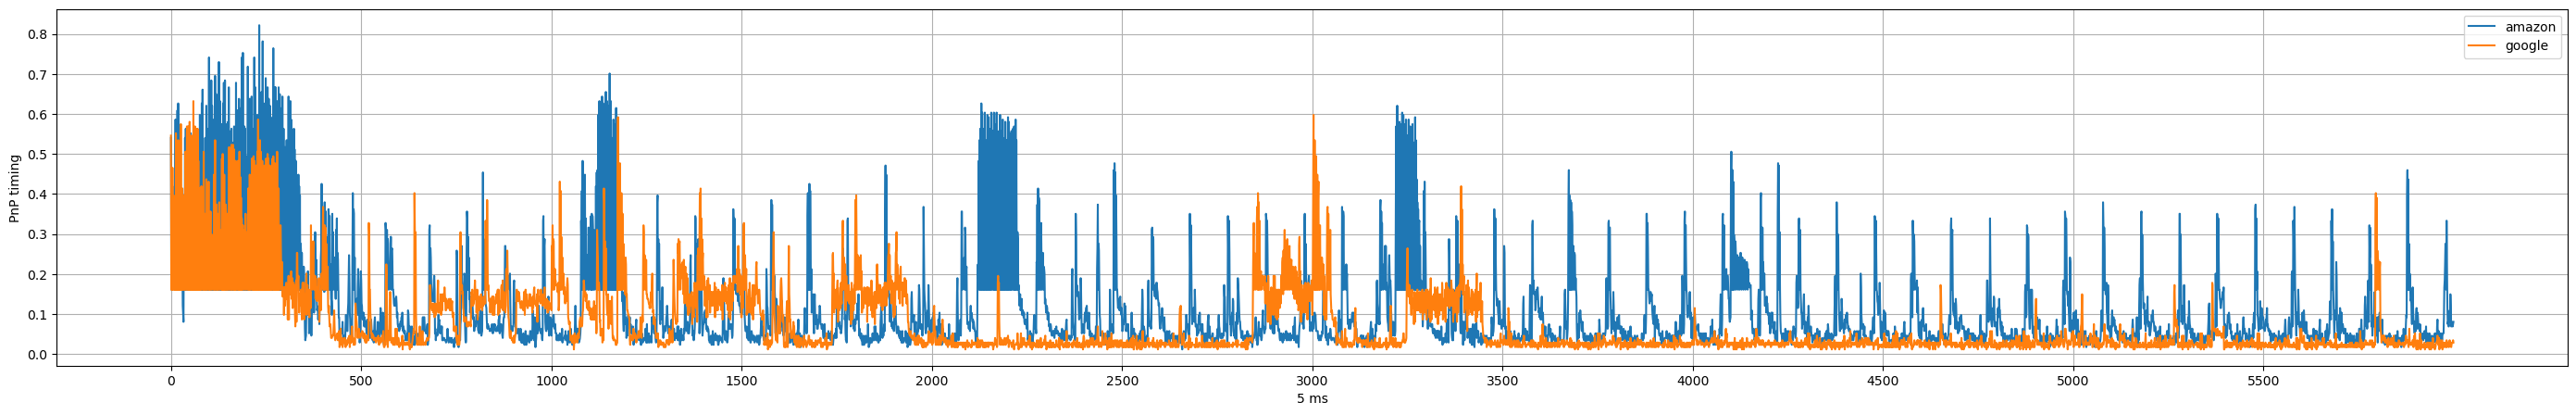

In [12]:
fig = plt.figure(figsize=(35,5))

#First Website Cluster: Amazon.com
plt.plot(trainX_Shuffled[0],label='amazon')

#Second Website Cluster: Google.com
plt.plot(trainX_Shuffled[100],label='google')

plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")


In [13]:
# encoding dimension; i.e. dimensionality of the latent space
# Website 2 for 2 dimension 100 for 100 dimension
latent_dim = 2

In [14]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon


# VAE (Encoder) 

In [15]:
inputs_shape = (samples,1)

# Encoder architecture: Input -> Conv1D*4 -> Flatten -> Dense
encoder_inputs = Input(shape=inputs_shape)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
#x = MaxPooling1D(pool_size=4)(x)
x = layers.Conv1D(128, 3, activation="relu", padding="same")(x)
#x = MaxPooling1D(pool_size=4)(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

print(z_mean.shape, z_log_var.shape)
# sample vector from the latent distribution
z = Lambda(sampling)([z_mean, z_log_var])


encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(None, 2) (None, 2)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 32)     128         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 6000, 64)     6208        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 6000, 128)    24704       ['conv1d_1[0][0]']               
                                                                        

# VAE(Decoder)

In [16]:
# decoder takes the latent distribution sample as input
print(K.int_shape(z)[1:])
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)
print(x.shape)

# use Conv1DTranspose to reverse the conv layers from the encoder
x = Conv1DTranspose(128, 3, padding='same', activation='relu')(x)
#x = UpSampling1D(size=4)(x)
x = Conv1DTranspose(64, 3, padding='same', activation='relu')(x)
#x = UpSampling1D(size=4)(x)
x = Conv1DTranspose(32, 3, padding='same', activation='relu')(x)

x = Conv1D(1, 1, padding='same', activation='sigmoid')(x)



# decoder model statement
decoder = Model(decoder_input, x)
z_decoder = decoder(z)
decoder.summary()

(2,)
(None, 6000, 128)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 768000)            2304000   
                                                                 
 reshape (Reshape)           (None, 6000, 128)         0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 6000, 128)        49280     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 6000, 64)         24640     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 6

In [17]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis =(1))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=0))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [18]:
batchSize = 2

In [19]:
vae = VAE(encoder, decoder)
print(vae)
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='reconstruction_loss', min_delta=0, patience=20, verbose=5, mode='auto')

#For 2 websites 
vae.fit(trainX_Shuffled, epochs=300,batch_size=batchSize, callbacks=[early_stopping])

Epoch 1/300
100/100 [==============================] - 5s 6ms/step - loss: 3885.2967 - reconstruction_loss: 2626.0618 - kl_loss: 119.7051
Epoch 2/300
100/100 [==============================] - 1s 6ms/step - loss: 1623.5079 - reconstruction_loss: 1633.9500 - kl_loss: 10.6131
Epoch 3/300
100/100 [==============================] - 1s 6ms/step - loss: 1686.9435 - reconstruction_loss: 1625.3354 - kl_loss: 5.2853
Epoch 4/300
100/100 [==============================] - 1s 6ms/step - loss: 1638.3522 - reconstruction_loss: 1618.3584 - kl_loss: 4.2631
Epoch 5/300
100/100 [==============================] - 1s 6ms/step - loss: 1616.5495 - reconstruction_loss: 1615.0640 - kl_loss: 3.8688
Epoch 6/300
100/100 [==============================] - 1s 6ms/step - loss: 1639.5704 - reconstruction_loss: 1613.0615 - kl_loss: 3.4316
Epoch 7/300
100/100 [==============================] - 1s 5ms/step - loss: 1582.6291 - reconstruction_loss: 1611.5864 - kl_loss: 3.2257
Epoch 8/300
100/100 [========================

# Plotting the Latent space (After the Encoder)

In [20]:
# Translate into the latent space
encoder = Model(encoder_inputs, z_mean)

100/100 [==============================] - 0s 1ms/step


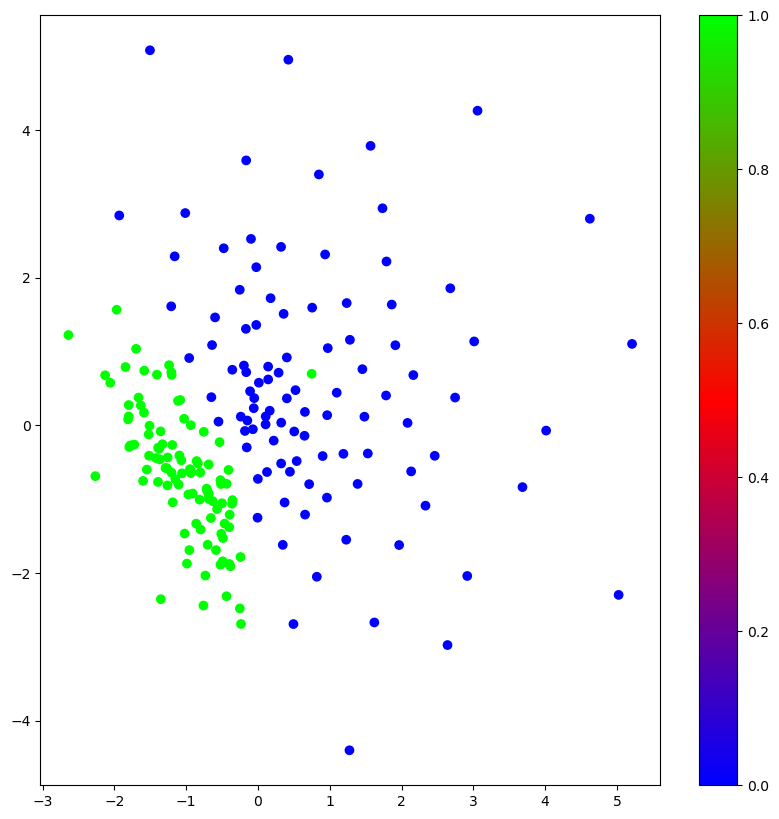

In [21]:
X_valid_encoded_ori = encoder.predict(trainX_test, batch_size=batchSize)
plt.figure(figsize=(10, 10))
plt.scatter(X_valid_encoded_ori[:, 0], X_valid_encoded_ori[:, 1],c=trainY, cmap='brg')
plt.colorbar()

# Plotting the modified Latent space (After the Encoder)

In [22]:
# Translate into the latent space
Encoder_spread = Model(encoder_inputs, z_mean)

100/100 [==============================] - 0s 1ms/step
-----
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------


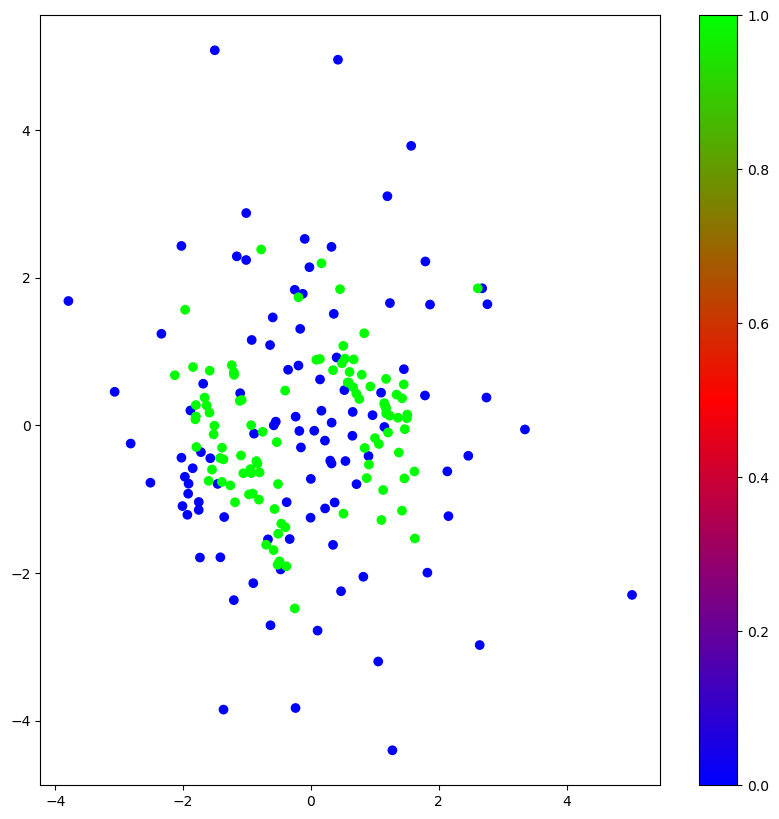

----------------------------------------------------------------


In [23]:
X_valid_encoded_new = Encoder_spread.predict(trainX_test, batch_size=batchSize)
print("-----")

#Seperating Website Clusters based on the original WF dataset
step = 100
#This can be changed based on the number of Websites
Num_websites = website_num
measurement = 100

websites = [X_valid_encoded_new[i:i + step] for i in range(0, len(X_valid_encoded_new), step)]
websites = np.asarray(websites)

print('----------------------------------------------------------------')

#Step 1 
#Each Mean point of the Website's Cluster 
mean = [np.mean(websites[i,:],axis=0) for i in range(0, Num_websites)]
mean = np.asarray(mean)



#Step 2
#Calculating the distance between each website
print('----------------------------------------------------------------')
dist = np.ones((Num_websites,Num_websites,latent_dim))

for i in range (0,Num_websites):
    for k in range (0,Num_websites):
        dist[i,k,:] = mean[i,:] - mean[k,:]
        
#Step 3 
# expanded to 100 measurements since we have 100 measurements of each website
Dis_ex_each = np.zeros((Num_websites,measurement,latent_dim))
print('----------------------------------------------------------------')
for i in range (0,100,Num_websites):
    Dis_ex_each [:,0+i:Num_websites+i,:] = dist

print('----------------------------------------------------------------')

#Step 4
#Spread separate clusters based on the mean value of each website cluster
Website_Noise_each_web = websites - Dis_ex_each

print('----------------------------------------------------------------')    

# Reshaping
#Website_Noise_mean=np.reshape(Website_Noise_mean,(Num_websites*measurement,latent_dim))
Website_Noise_each_web=np.reshape(Website_Noise_each_web,(Num_websites*measurement,latent_dim))

plt.figure(figsize=(10, 10))
plt.scatter(Website_Noise_each_web[:, 0], Website_Noise_each_web[:, 1],c=trainY, cmap='brg')
plt.colorbar()
plt.show()
print('----------------------------------------------------------------')


# Re-constructed WF dataset from the VAE
### This is to validate VAE.


In [24]:
z_mean, z_log_var, z = vae.encoder.predict(trainX_test)
re_generated_x = vae.decoder.predict(z)

7/7 [==============================] - 0s 14ms/step


# Plot the re-constructed WF

Text(0, 0.5, 'PnP timing')

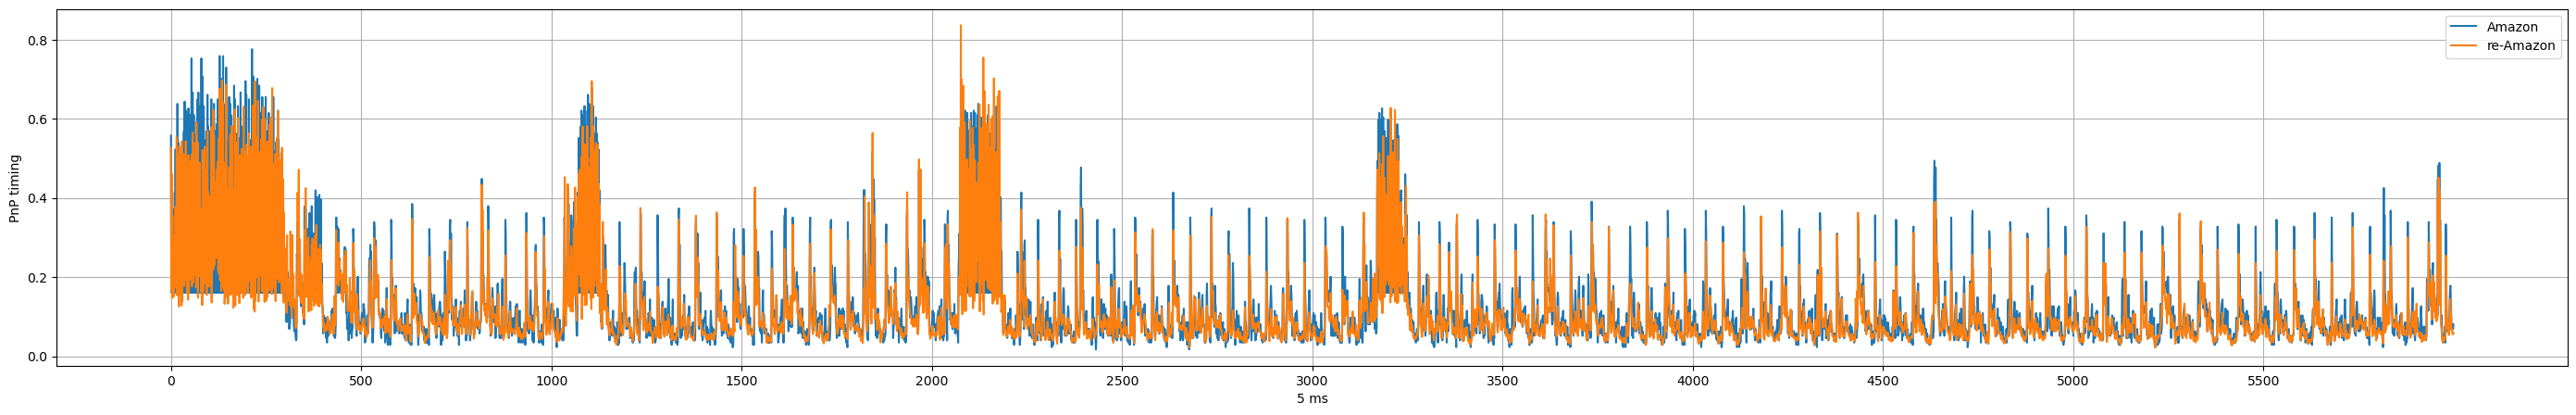

In [25]:
fig = plt.figure(figsize=(35,5))

plt.plot(trainX_test[1],label='Amazon')
plt.plot(re_generated_x[1],label='re-Amazon')

plt.legend()

plt.xticks(np.arange(0, samples, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")


# Load the Pre-trained CNN model

In [26]:
#Website 2
classification_model = tf.keras.models.load_model('../../Attack_Model/CNN_Pretrained_Model_chrome_W2.h5')


In [27]:
re_generated_x_save = np.squeeze(re_generated_x)

In [28]:
trainY_ca= keras.utils.to_categorical(trainY)

In [29]:
prediction = np.argmax(classification_model.predict(re_generated_x_save), axis=1)
print(prediction[0:2000])

7/7 [==============================] - 0s 5ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [30]:
test = classification_model.predict(re_generated_x_save)


7/7 [==============================] - 0s 3ms/step


In [31]:
score = classification_model.evaluate(re_generated_x_save, trainY_ca, verbose=0)
print(" loss:", score[0])
print("accuracy:", score[1])
print(score)

 loss: 0.044846102595329285
accuracy: 0.9950000047683716
[0.044846102595329285, 0.9950000047683716]


In [32]:
new_z_each = Lambda(sampling)([Website_Noise_each_web, z_log_var])

In [33]:
generated_x_noise_each = vae.decoder.predict(new_z_each)

7/7 [==============================] - 0s 3ms/step
(200, 6000, 1)


Text(0, 0.5, 'PnP timing')

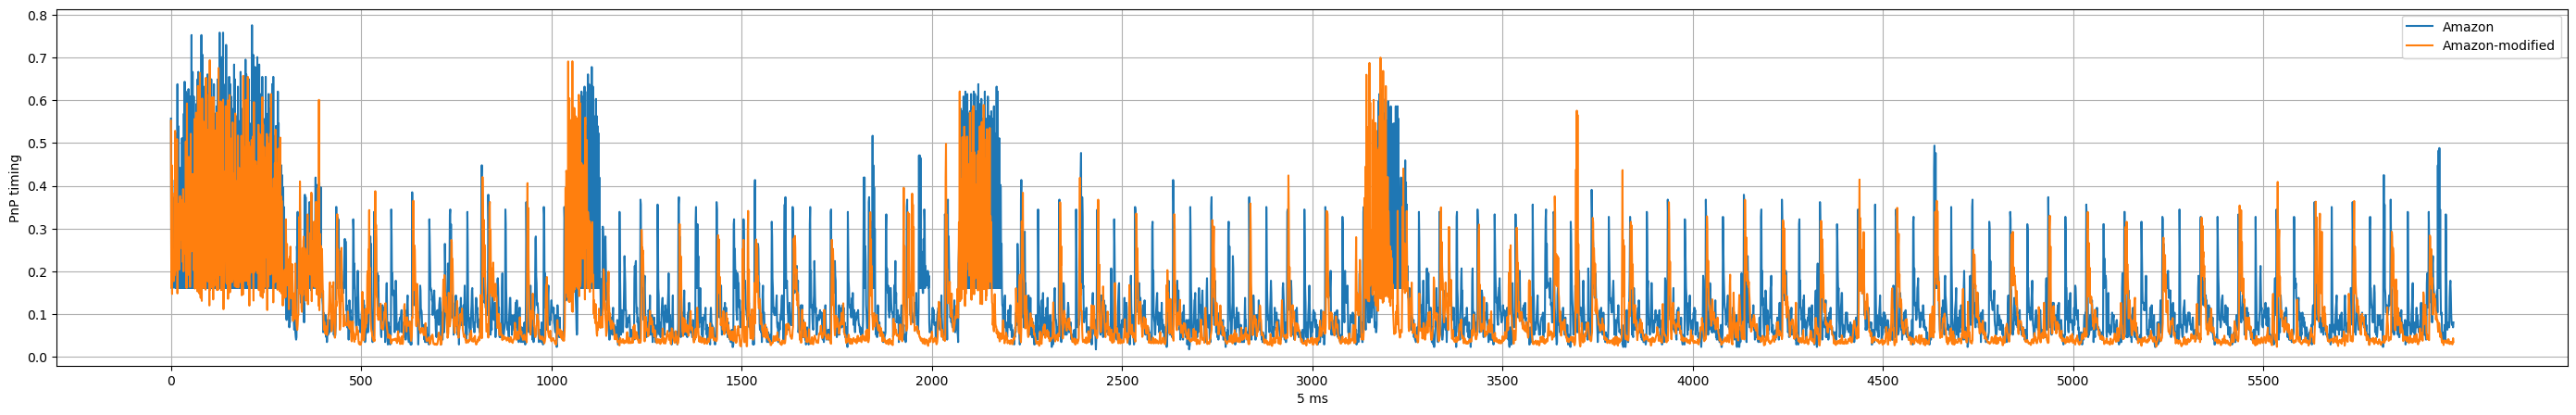

In [34]:
fig = plt.figure(figsize=(35,5))
plt.plot(trainX_test[1],label='Amazon')
plt.plot(generated_x_noise_each[1],label='Amazon-modified')

plt.legend()
plt.xticks(np.arange(0, samples, 500))
plt.grid()
plt.xlabel("5 ms")
plt.ylabel("PnP timing")


In [35]:
generated_x_noise_each_save = np.squeeze(generated_x_noise_each)

In [36]:
prediction_new = np.argmax(classification_model.predict(generated_x_noise_each_save), axis=1)

print(prediction_new.shape)
print(prediction_new[0:1000])

7/7 [==============================] - 0s 3ms/step
(200,)
[0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [37]:
score_noise = classification_model.evaluate(generated_x_noise_each_save, trainY_ca, verbose=0)
print(" loss:", score_noise[0])
print("accuracy:", score_noise[1])
print(score_noise)


 loss: 10.367923736572266
accuracy: 0.5799999833106995
[10.367923736572266, 0.5799999833106995]


# Save reconstructed WF dataset and noisy WF dataset

In [38]:
with open('reconstructed_x_chrome_w2.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(re_generated_x_save)

with open('reconstructed_nosiy_x_chrome_w2.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(generated_x_noise_each_save)

## *From here we are creation noise template with 100 websites. which is already avaiable in ../Noise_Template directory

## Python code (DefWeb_Autorun.sh) is avaiable to run Automnatically run and get accuracy



# Noise Template Creation (For 100 Websites)

In [ ]:
def accuracy_fuction_test(test_website,test_measure):
    ex = np.zeros((measurement,latent_dim))
    ####dist saved(Oct 6)#########
    for i in range (0,measurement):
        ex[i,:] = dist[test_website,test_measure,:]   #if web 0, meausrement 5 -> dist[web0,meauremet5]
    
    print('----------------------------------------------------------------')
    ex_total= np.zeros((Num_websites,measurement,latent_dim))
    for k in range (0,100,Num_websites):
        ex_total[:,0+k:Num_websites+k,:] = ex
    ####Websites saved(Oct 6)#########
    Website_Noise_each_web_test = websites - ex_total
    Website_Noise_each_web_test=np.reshape(Website_Noise_each_web_test,(Num_websites*measurement,latent_dim))
    new_z_each_test = Lambda(sampling)([Website_Noise_each_web_test, z_log_var])
    #new_z = Lambda(sampling)([z_mean, z_log_var])
    #print(new_z)
    np.array(new_z_each_test)
    #print(type(new_z_each_test))
    #DECODER
    generated_x_noise_each_test = vae.decoder.predict(new_z_each_test)
    #generated_x_noise_each_test = vae_decoder_test.predict(new_z_each_test)
    generated_x_noise_each_test_save = np.squeeze(generated_x_noise_each_test)
    return generated_x_noise_each_test,generated_x_noise_each_test_save

In [ ]:
for i in range (0,Num_websites):
    for k in range (0,Num_websites):
        print("-------------",i,"-th website to ",k,"-th website ---------------------")
        test, test_save=accuracy_fuction_test(i,k)
        denormalized_Noise_data = test_save * (maximum-minimum) + minimum
        trainO=np.reshape(trainX,(Num_websites*100,samples))
        Only_noise =denormalized_Noise_data-trainO
        print('Noise only Zeroed----------------------------------------------------------------')
        print("Only_noise")
        print(Only_noise.shape)
        print(Only_noise.min(), Only_noise.max() )
        #print(Only_noise)
        noise_zeroized = np.where(Only_noise<0, 0, Only_noise)
        mean_noise = np.zeros((1,samples))
        #print(mean_noise.shape)
        #print(mean_noise)
        #print(mean_noise[:,0])
        t=0
        for j in range (0,samples):
            for p in range(0,100):
                t+=noise_zeroized[i*100:i*100+100][p][j]
            mean_noise[:,j]= t/100
            t=0
        print('mean noise')
        #print(mean_noise)
        print(mean_noise.shape)
        print("max: ", mean_noise.max())
        print("min: ", mean_noise.min())
        mean_noise_max= mean_noise.max()
        mean_noise_min= mean_noise.min()
        #print(test_mean[0:100])
        print('Noise co3 zeroed----------------------------------------------------------------')
        co_value = 3
        temp = np.ones((Num_websites*100,samples))
        shift_up_co = Only_noise.min()/co_value * temp
        Only_noise_shift_co = Only_noise - shift_up_co
        print(Only_noise_shift_co.min(),Only_noise_shift_co.max())
        Only_noise_shift_co = np.where(Only_noise_shift_co<0, 0, Only_noise_shift_co)
        print(Only_noise_shift_co.min(),Only_noise_shift_co.max())

        mean_noise_co3 = np.zeros((1,samples))
        #print(mean_noise.shape)
        #print(mean_noise)
        #print(mean_noise[:,0])
        t=0

        for j in range (0,samples):
            for p in range(0,100):
                t+=Only_noise_shift_co[i*100:i*100+100][p][j]
            mean_noise_co3[:,j]= t/100
            t=0
           
        

        print('co3_mean noise')
        #print(mean_noise)
        print(mean_noise_co3.shape)
        print("co3_max: ", mean_noise_co3.max())
        print("co3_min: ", mean_noise_co3.min())
        
        mean_noise_co_3_max= mean_noise_co3.max()
        mean_noise_co_3_min= mean_noise_co3.min()
        #print(test_mean[0:100])
        print('----------------------------------------------------------------')
        
 
        #with open(f'TempleteCreation/AverageTemplate_GC_zero_{i}_{k}.csv', 'w', newline='') as file:
        #    mywriter = csv.writer(file, delimiter=',')
        #    mywriter.writerows(mean_noise)
    

        #print("-----------------------------End----------------------------------------")
        
        # MAKE DIRECTORY IF YOU WANT TO SAVE NOISE TEMPLATE
        with open(f'../../test/AverageTemplate_GC_co3_{i}_{k}.csv', 'w', newline='') as file:
            mywriter = csv.writer(file, delimiter=',')
            mywriter.writerows(mean_noise_co3)
            
        print("-----------------------------End----------------------------------------")
        
        
        #MAXIMUM and MINIMUM VALUE  to see how much noise need in order to deal with SMC Noise
        with open(f'../../test1/AverageTemplate_GC_co3_Max_{i}.txt', 'a',encoding='utf-8') as f:
            f.write(str(mean_noise_co_3_max)+'\n')
            
        with open(f'../../test1/AverageTemplate_GC_co3_Min_{i}.txt', 'a', encoding='utf-8') as f:
            f.write(str(mean_noise_co_3_min)+'\n')
            
        print("-----------------------------End----------------------------------------")



# End of the Demo version